<a href="https://colab.research.google.com/github/fatmaT2001/CustomSVM_Implementation/blob/main/SVM_From_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from cvxopt import matrix, solvers
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Kernals

## RBF

In [ ]:
def rbf_kernel(X1, X2, gamma=0.1):
    """
    Computes the Radial Basis Function (RBF) kernel between two sets of vectors.

    Args:
    X1: A 2D NumPy array where each row represents a vector (data point).
    X2: Another 2D NumPy array where each row represents a vector (data point).
    gamma: The gamma parameter for the RBF kernel.

    Returns:
    K: A 2D NumPy array representing the RBF kernel matrix..
    """

    # Calculate the squared Euclidean distances between each pair of points in X1 and X2
    sq_dists = np.sum(X1**2, axis=1).reshape(-1, 1) + np.sum(X2**2, axis=1) - 2 * np.dot(X1, X2.T)

    # Apply the RBF kernel formula
    K = np.exp(-gamma * sq_dists)

    return K



## Linear

In [ ]:
def linear_kernel(X1, X2):
    return np.dot(X1, X2.T)


## Polynomia

In [ ]:
def polynomial_kernel(X1, X2, degree=2, coef0=1):
    return (np.dot(X1, X2.T) + coef0) ** degree


#Solver

In [ ]:
def solve_for_alphas_cvxopt(H, f, A_eq, b_eq, C, m):
    """
    Solves the quadratic programming problem for SVM using the CVXOPT library.

    This function finds the Lagrange multipliers (alphas) for the SVM's optimization problem.
    It is specifically tailored for solving the dual problem of SVMs with the RBF kernel.

    Args:
    H (np.ndarray): The Hessian matrix, which is the matrix of the RBF kernel values multiplied by the label products.
    f (np.ndarray): The linear term in the quadratic problem, typically a vector of -1's.
    A_eq (np.ndarray): The equality constraint matrix (for the SVM, this is typically the label vector).
    b_eq (np.ndarray): The equality constraint value (for the SVM, this is typically an array containing a single zero).
    C (float): The regularization parameter, controlling the trade-off between maximizing the margin and minimizing the classification error.
    m (int): The number of training samples.

    Returns:
    np.ndarray: A 1D array of Lagrange multipliers (alphas).
    """

    # Convert numpy arrays to CVXOPT matrices
    P = matrix(H, tc='d')
    q = matrix(f, tc='d')
    G = matrix(np.vstack((-np.eye(m), np.eye(m))), tc='d')
    h = matrix(np.hstack((np.zeros(m), np.ones(m) * C)), tc='d')

    A = matrix(A_eq, tc='d')
    b = matrix(b_eq, tc='d')

    # Solve the quadratic programming problemd
    sol = solvers.qp(P, q, G, h, A, b)

    # Extract the alphas and flatten the array to 1D
    alphas = np.array(sol['x']).flatten()

    return alphas


# calculate the bias term

In [ ]:
import numpy as np

def calculate_b(X_train, y_train, alphas, C,kernal):
    """
    Calculate the bias term for an SVM with an RBF kernel.

    Args:
    X_train (np.ndarray): Training data features, where each row is a data point.
    y_train (np.ndarray): Training data labels.
    alphas (np.ndarray): Lagrange multipliers for the SVM.
    gamma (float): The gamma parameter for the RBF kernel.
    C (float): The regularization parameter.

    Returns:
    float: The calculated bias term.
    """

    if kernal=='linear':
        # kernel for support vectors
        K_supp = linear_kernel(X_train, X_train)
    elif kernal=='poly':
        # kernel for support vectors
        K_supp = polynomial_kernel(X_train, X_train)
    else:
        # RBF kernel for support vectors
        K_supp = rbf_kernel(X_train, X_train, 0.1)

    # Calculate the bias term using support vectors
    b = np.mean(y_train - np.sum(K_supp * alphas * y_train, axis=1))

    return b


## fitinng

In [ ]:
def fit_svm(X_train, y_train, C,kernal):
    """
    Trains the SVM model using an RBF kernel.

    Args:
    X_train (np.ndarray): Training data features, where each row is a data point.
    y_train (np.ndarray): Training data labels (must be binary: 0 or 1).
    C (float): The regularization parameter.

    Returns:
    np.ndarray: A 1D array of Lagrange multipliers (alphas).
    float: The calculated bias term.
    """
    # Convert labels from 0 to -1
    y_train = y_train.copy()
    y_train[y_train == 0] = -1

    # Number of training samples
    m = y_train.shape[0]

    # Initialize the linear term in the quadratic problem
    f = -np.ones(m)

    # Equality constraints
    A_eq = y_train.reshape(1, -1).astype(np.double)  # Ensure it's a 2D array of type double
    b_eq = np.double([0.0])  # Ensure it's a 2D array of type double

    # Solve the quadratic programming problem to find alphas
    if kernal=='linear':
        # kernel for support vectors
        Kernal_value = linear_kernel(X_train, X_train)
    elif kernal=='poly':
        # kernel for support vectors
        Kernal_value = polynomial_kernel(X_train, X_train)
    else:
        # RBF kernel for support vectors
        Kernal_value = rbf_kernel(X_train, X_train)
    alphas = solve_for_alphas_cvxopt(Kernal_value, f, A_eq, b_eq, C, m)

    # Calculate the bias term b
    b= calculate_b(X_train, y_train, alphas, C,kernal)

    return alphas, b


## predict

In [ ]:
def predict_svm(X_test, X_train, y_train, alphas, b,kernal):
    """
    Makes predictions using the trained SVM model with an RBF kernel.

    Args:
    X_test (np.ndarray): Test data features, where each row is a data point.
    X_train (np.ndarray): Training data features used for SVM training.
    y_train (np.ndarray): Training data labels used for SVM training (must be binary: -1 or 1).
    alphas (np.ndarray): Lagrange multipliers obtained from SVM training.
    b (float): The bias term obtained from SVM training.

    Returns:
    np.ndarray: A 1D array containing the predicted labels (0 or 1).
    """
     # Solve the quadratic programming problem to find alphas
    if kernal=='linear':
        # kernel for support vectors
        Kernal_value = linear_kernel(X_test, X_train)
    elif kernal=='poly':
        # kernel for support vectors
        Kernal_value = polynomial_kernel(X_test, X_train)
    else:
        # RBF kernel for support vectors
        Kernal_value = rbf_kernel(X_test, X_train)
    # Compute the decision function
    decision = np.dot(Kernal_value, alphas * y_train) + b

    # Make predictions based on the sign of the decision function
    y_pred = np.sign(decision)
    y_pred[y_pred == -1] = 0

    return y_pred


#Test

In [ ]:


def multiclass_SVM(X, y, C=1):
    labels = np.unique(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    kernels = ["RBF","linear","poly"]

    fig, axes = plt.subplots(1, len(kernels), figsize=(15, 4))

    for ax, kernel_name in zip(axes, kernels):
        y_hat = -np.ones(y_test.shape[0])

        for label in labels:
            y_train_clf = y_train.copy()
            y_train_clf[y_train == label] = 1
            y_train_clf[y_train != label] = 0

            alphas, b = fit_svm(X_train, y_train_clf, C, kernel_name)
            y_hat_clf = predict_svm(X_test, X_train, y_train_clf, alphas, b, kernel_name)
            y_hat[y_hat_clf == 1] = label

        acc = accuracy_score(y_test, y_hat)
        print(f"Accuracy of {kernel_name} kernel: {acc * 100}%")

        # Scatter plot for test data
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_hat, cmap='viridis', marker='o', alpha=0.7, label='Predicted')
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis', marker='+', alpha=0.3, label='Training Data')
        ax.set_title(f"{kernel_name} Kernel\nAccuracy: {acc * 100:.2f}%")
        ax.set_xlabel('Feature 1')
        ax.set_ylabel('Feature 2')
        ax.legend()

    plt.tight_layout()
    plt.show()


## Spiral

     pcost       dcost       gap    pres   dres
 0:  1.0890e+01 -6.5806e+02  7e+02  2e-15  7e-16
 1: -8.8820e+00 -5.6137e+01  5e+01  7e-16  9e-16
 2: -1.2480e+01 -1.5784e+01  3e+00  1e-15  3e-16
 3: -1.2645e+01 -1.3423e+01  8e-01  1e-15  2e-16
 4: -1.2698e+01 -1.2909e+01  2e-01  1e-15  2e-16
 5: -1.2728e+01 -1.2812e+01  8e-02  6e-16  2e-16
 6: -1.2738e+01 -1.2759e+01  2e-02  9e-16  2e-16
 7: -1.2742e+01 -1.2747e+01  5e-03  5e-16  2e-16
 8: -1.2743e+01 -1.2744e+01  6e-04  3e-16  2e-16
 9: -1.2743e+01 -1.2743e+01  7e-05  2e-15  2e-16
10: -1.2743e+01 -1.2743e+01  2e-06  2e-15  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.0846e+01 -6.6024e+02  7e+02  3e-15  8e-16
 1: -8.8847e+00 -5.5329e+01  5e+01  2e-15  9e-16
 2: -1.2465e+01 -1.6253e+01  4e+00  5e-16  3e-16
 3: -1.2652e+01 -1.3403e+01  8e-01  6e-16  2e-16
 4: -1.2703e+01 -1.2894e+01  2e-01  4e-16  2e-16
 5: -1.2726e+01 -1.2780e+01  5e-02  2e-16  2e-16
 6: -1.2735e+01 -1.2752e+01  2e-02  1e-15  2e-1

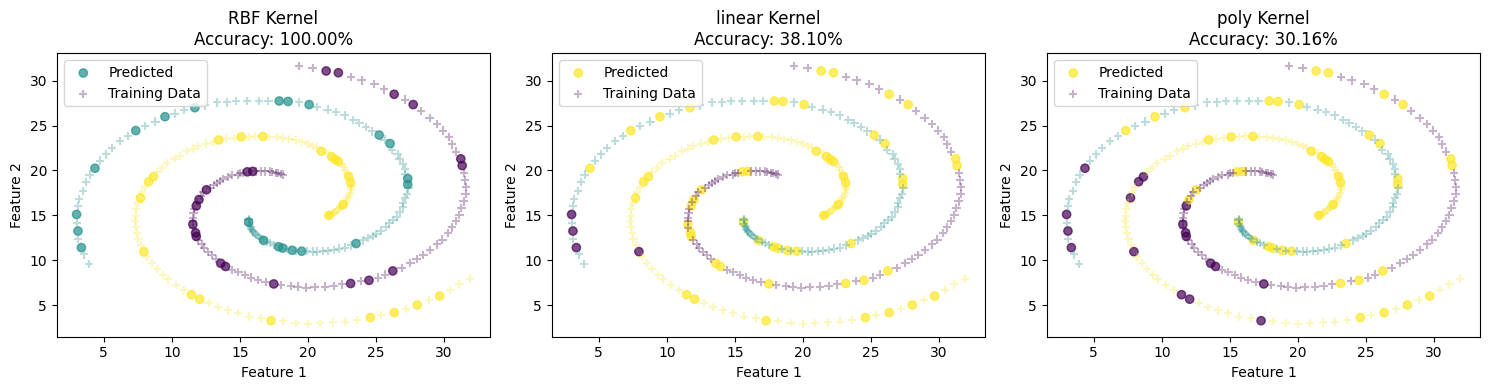

In [ ]:
import pandas as pd
# Load your Spiral dataset
sprial_df = pd.read_csv("Spiral.txt", skiprows=7, sep="\t", header=None, names=["x1", "x2", "class"])
X, y = sprial_df.drop(columns=["class"]).values, sprial_df["class"].values - 1

# Apply the multiclass SVM function to your data
multiclass_SVM(X, y, C=2)

## Flame

     pcost       dcost       gap    pres   dres
 0: -1.9535e+00 -2.2873e+02  9e+02  2e+00  4e-16
 1:  1.3914e+00 -8.4363e+01  9e+01  2e-02  5e-16
 2: -3.0690e+00 -8.9761e+00  6e+00  8e-04  5e-16
 3: -3.7644e+00 -5.0417e+00  1e+00  1e-04  4e-16
 4: -4.0123e+00 -4.5119e+00  5e-01  3e-05  4e-16
 5: -4.1331e+00 -4.2494e+00  1e-01  3e-06  4e-16
 6: -4.1625e+00 -4.1941e+00  3e-02  7e-07  4e-16
 7: -4.1707e+00 -4.1845e+00  1e-02  6e-08  4e-16
 8: -4.1746e+00 -4.1779e+00  3e-03  1e-08  4e-16
 9: -4.1756e+00 -4.1762e+00  6e-04  2e-09  4e-16
10: -4.1759e+00 -4.1759e+00  2e-05  3e-11  5e-16
11: -4.1759e+00 -4.1759e+00  3e-07  4e-13  5e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.9535e+00 -2.2873e+02  9e+02  2e+00  4e-16
 1:  1.3914e+00 -8.4363e+01  9e+01  2e-02  5e-16
 2: -3.0690e+00 -8.9761e+00  6e+00  8e-04  5e-16
 3: -3.7644e+00 -5.0417e+00  1e+00  1e-04  4e-16
 4: -4.0123e+00 -4.5119e+00  5e-01  3e-05  4e-16
 5: -4.1331e+00 -4.2494e+00  1e-01  3e-06  4e-1

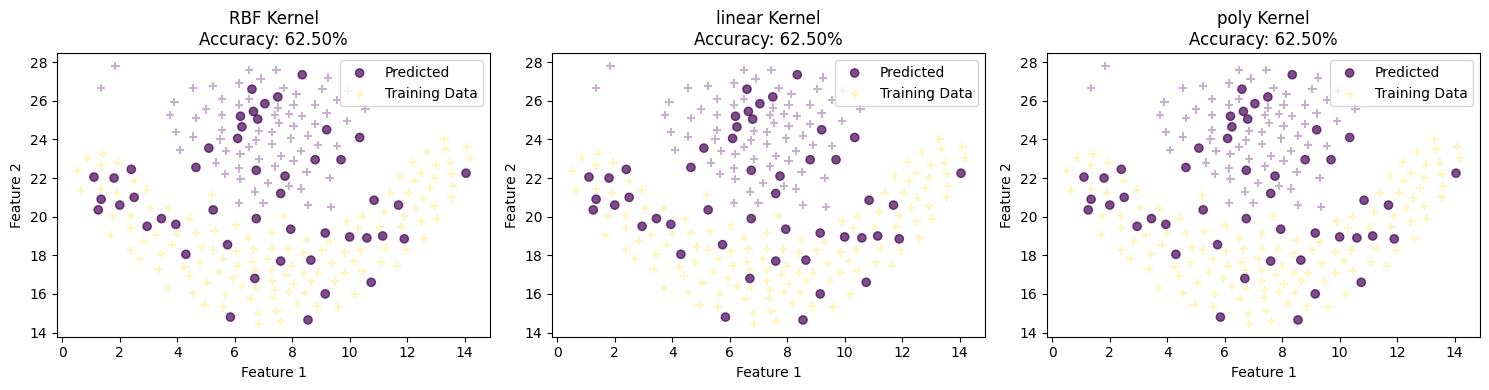

In [ ]:
import pandas as pd
# Load your Spiral dataset
sprial_df = pd.read_csv("Flame.txt", skiprows=7, sep="\t", header=None, names=["x1", "x2", "class"])
X, y = sprial_df.drop(columns=["class"]).values, sprial_df["class"].values - 1

# Apply the multiclass SVM function to your data
multiclass_SVM(X, y, C=1)